In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

11.2.1
d:\Anaconda3\envs\bayesian\python.exe


In [45]:
BASE_DIR=os.getcwd()
csv_path = os.path.join(BASE_DIR,"cleaned_data.csv")
outputPath = os.path.join(BASE_DIR,"Bayesian_Model.pkl")
df = pd.read_csv(csv_path)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60428 entries, 0 to 60427
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   food_category               60428 non-null  int64  
 1   food_department             60428 non-null  int64  
 2   food_family                 60428 non-null  int64  
 3   store_sales(in millions)    60428 non-null  int64  
 4   store_cost(in millions)     60428 non-null  int64  
 5   unit_sales(in millions)     60428 non-null  float64
 6   promotion_name              60428 non-null  int64  
 7   sales_country               60428 non-null  int64  
 8   marital_status              60428 non-null  int64  
 9   gender                      60428 non-null  int64  
 10  total_children              60428 non-null  float64
 11  education                   60428 non-null  int64  
 12  member_card                 60428 non-null  int64  
 13  occupation                  604

In [46]:
def learn_bayesian_network(df):
    # df, encoders = preprocess_data(df, target_col)
    
    # Split into train and test
    train_data, test_data = train_test_split(df, test_size=0.02, random_state=42)
    
    # Learn structure
    hc = HillClimbSearch(train_data)
    best_model = hc.estimate(scoring_method=BicScore(train_data))
    print(best_model.edges())
    # Learn parameters
    model = BayesianModel(best_model.edges())
    model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")

    return model, test_data, df.columns[-1]

def predict(model, test_data, target_col):
    infer = VariableElimination(model)
    model_vars = set(model.nodes())
    y_pred = []
    # i = 0
    for _, row in test_data.drop(columns=[target_col]).iterrows():
        evidence = {k: v for k, v in row.to_dict().items() if k in model_vars}
        q = infer.map_query([target_col], evidence=evidence,show_progress=False)
        # print(q,test_data[target_col].iloc[i])
        # if isinstance(q, dict):
        y_pred.append(q[target_col])
        # else:
        #     y_pred.append(q)
        # i+=1
    return y_pred

In [47]:
model, test_data, target_col = learn_bayesian_network(df)

#Make predictions on the test data
print("Model variables:", model.nodes())
predictions = predict(model, test_data, target_col)

  0%|          | 79/1000000 [01:57<412:03:45,  1.48s/it]
d:\Anaconda3\envs\bayesian\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


[('food_category', 'food_department'), ('food_department', 'brand_name'), ('food_department', 'food_family'), ('food_department', 'gross_weight'), ('store_sales(in millions)', 'SRP'), ('store_sales(in millions)', 'unit_sales(in millions)'), ('store_cost(in millions)', 'store_sales(in millions)'), ('store_cost(in millions)', 'SRP'), ('unit_sales(in millions)', 'SRP'), ('unit_sales(in millions)', 'total_children'), ('promotion_name', 'store_city'), ('promotion_name', 'media_type'), ('promotion_name', 'cost'), ('marital_status', 'num_children_at_home'), ('marital_status', 'houseowner'), ('marital_status', 'avg. yearly_income'), ('gender', 'houseowner'), ('gender', 'avg. yearly_income'), ('gender', 'marital_status'), ('total_children', 'num_children_at_home'), ('total_children', 'avg. yearly_income'), ('total_children', 'gender'), ('total_children', 'marital_status'), ('occupation', 'education'), ('houseowner', 'num_children_at_home'), ('avg_cars_at home(approx)', 'avg_cars_at home(approx)

In [48]:
# Show the predictions
# print('test data: ', test_data[:10])
# print("Predictions:", predictions[:10])  # Show first 10 predictions
# accuracy = sum(1 for i in range(len(predictions)) if test_data[target_col].iloc[i]==predictions[i]) /len(predictions)
# print('accuracy: ', accuracy)
true_labels = test_data[target_col].iloc[:len(predictions)]
predicted_labels = predictions
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       242
           1       0.93      0.97      0.95       256
           2       0.95      0.90      0.92       236
           3       0.90      0.90      0.90       243
           4       0.98      0.92      0.95       232

    accuracy                           0.93      1209
   macro avg       0.93      0.93      0.93      1209
weighted avg       0.93      0.93      0.93      1209



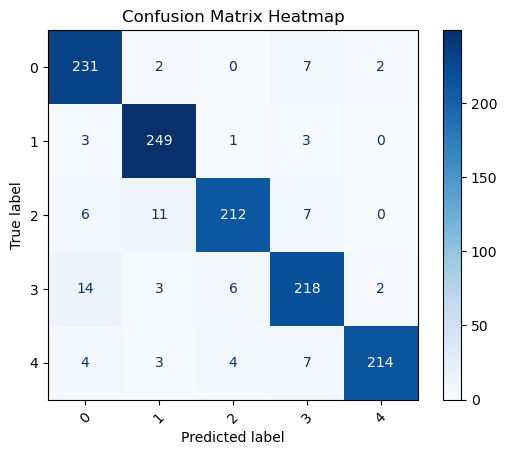

In [49]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.states[target_col])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Heatmap")
plt.show()